In [1]:
!pip install -q gymnasium[classic-control] torch numpy matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 105.7 MB/s eta 0:00:00


In [2]:
import math, random, time
from collections import deque
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden=128):
        super().__init__()
        self.trunk = nn.Sequential(
            nn.Linear(state_dim, hidden), nn.Tanh(),
            nn.Linear(hidden, hidden), nn.Tanh(),
        )
        self.actor = nn.Linear(hidden, action_dim)
        self.critic = nn.Linear(hidden, 1)
    def forward(self, x):
        z = self.trunk(x)
        logits = self.actor(z)
        value = self.critic(z).squeeze(-1)
        return logits, value
    @torch.no_grad()
    def act(self, state):
        if not torch.is_tensor(state):
            state = torch.tensor(state, dtype=torch.float32, device=device)
        state = state.unsqueeze(0) if state.ndim == 1 else state
        logits, value = self.forward(state)
        dist = Categorical(logits=logits)
        action = dist.sample()
        logprob = dist.log_prob(action)
        return int(action.item()), float(logprob.item()), float(value.item())


In [4]:
class RolloutBuffer:
    def __init__(self):
        self.states = []; self.actions = []; self.logprobs = []
        self.rewards = []; self.dones = []; self.values = []
    def add(self, state, action, logprob, reward, done, value):
        self.states.append(state); self.actions.append(action)
        self.logprobs.append(logprob); self.rewards.append(reward)
        self.dones.append(done); self.values.append(value)
    def clear(self):
        self.__init__()


In [5]:
def compute_gae(rewards, dones, values, last_value, gamma=0.99, lam=0.95):
    T = len(rewards)
    adv = np.zeros(T, dtype=np.float32)
    lastgaelam = 0.0
    for t in reversed(range(T)):
        nonterminal = 1.0 - dones[t]
        next_value = last_value if t == T - 1 else values[t+1]
        delta = rewards[t] + gamma * next_value * nonterminal - values[t]
        lastgaelam = delta + gamma * lam * nonterminal * lastgaelam
        adv[t] = lastgaelam
    returns = adv + np.array(values, dtype=np.float32)
    return adv, returns


In [6]:
def ppo_update(model, optimizer, batch_states, batch_actions, batch_logprobs_old,
               batch_returns, batch_advs, clip_ratio=0.2, vf_coef=0.5,
               ent_coef=0.01, epochs=10, minibatch_size=64):
    model.train()
    N = batch_states.size(0)
    idxs = np.arange(N)
    for _ in range(epochs):
        np.random.shuffle(idxs)
        for start in range(0, N, minibatch_size):
            mb = idxs[start:start+minibatch_size]
            states = batch_states[mb]; actions = batch_actions[mb]
            logprobs_old = batch_logprobs_old[mb]
            returns = batch_returns[mb]; advs = batch_advs[mb]

            # normalize advantages
            advs = (advs - advs.mean()) / (advs.std() + 1e-8)

            logits, values = model(states)
            dist = Categorical(logits=logits)
            logprobs = dist.log_prob(actions)
            entropy = dist.entropy().mean()

            ratio = torch.exp(logprobs - logprobs_old)
            surr1 = ratio * advs
            surr2 = torch.clamp(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio) * advs
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = nn.MSELoss()(values, returns)
            loss = policy_loss + vf_coef * value_loss - ent_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()


Steps:   2048 | AvgReward(10ep):   19.50
Steps:   4096 | AvgReward(10ep):   24.10
Steps:   6144 | AvgReward(10ep):   57.40
Steps:   8192 | AvgReward(10ep):   60.70
Steps:  10240 | AvgReward(10ep):   88.20
Steps:  12288 | AvgReward(10ep):  118.10
Steps:  14336 | AvgReward(10ep):  192.10
Steps:  16384 | AvgReward(10ep):   31.40
Steps:  18432 | AvgReward(10ep):  198.80
Steps:  20480 | AvgReward(10ep):   54.60
Steps:  22528 | AvgReward(10ep):  118.00
Steps:  24576 | AvgReward(10ep):  121.30
Steps:  26624 | AvgReward(10ep):  127.60
Steps:  28672 | AvgReward(10ep):  152.80
Steps:  30720 | AvgReward(10ep):  124.50
Steps:  32768 | AvgReward(10ep):  108.40
Steps:  34816 | AvgReward(10ep):  151.70
Steps:  36864 | AvgReward(10ep):   89.20
Steps:  38912 | AvgReward(10ep):  169.10
Steps:  40960 | AvgReward(10ep):  165.10
Steps:  43008 | AvgReward(10ep):  269.20
Steps:  45056 | AvgReward(10ep):   91.00
Steps:  47104 | AvgReward(10ep):  242.60
Steps:  49152 | AvgReward(10ep):   83.60
Steps:  51200 | 

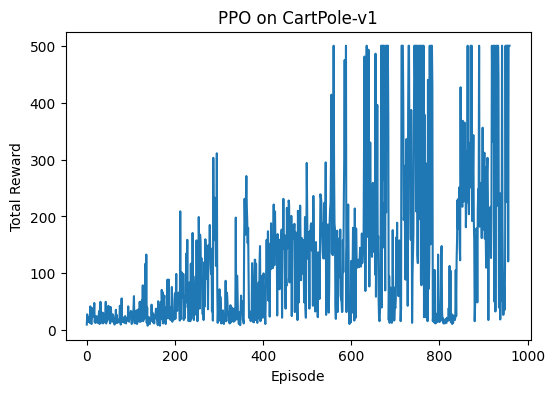

In [7]:
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = ActorCritic(state_dim, action_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

total_timesteps = 120_000
rollout_steps   = 2048
gamma = 0.99
gae_lambda = 0.95
clip_ratio = 0.2
vf_coef = 0.5
ent_coef = 0.01
update_epochs = 10
minibatch_size = 64

ep_rewards, reward_history = [], []
state, info = env.reset(seed=SEED)
buffer = RolloutBuffer()
timestep = 0

while timestep < total_timesteps:
    buffer.clear()
    steps = 0
    while steps < rollout_steps:
        action, logp, value = model.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        buffer.add(state, action, logp, reward, float(done), value)
        state = next_state; steps += 1; timestep += 1

        if len(ep_rewards) == 0: ep_rewards.append(0.0)
        ep_rewards[-1] += reward
        if done:
            reward_history.append(ep_rewards[-1])
            ep_rewards.append(0.0)
            state, info = env.reset()

    with torch.no_grad():
        s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        _, last_val = model(s_t)

    adv, returns = compute_gae(buffer.rewards, buffer.dones, buffer.values,
                               float(last_val.item()), gamma=gamma, lam=gae_lambda)

    batch_states = torch.tensor(np.array(buffer.states), dtype=torch.float32, device=device)
    batch_actions = torch.tensor(np.array(buffer.actions), dtype=torch.int64, device=device)
    batch_logprobs_old = torch.tensor(np.array(buffer.logprobs), dtype=torch.float32, device=device)
    batch_advs = torch.tensor(adv, dtype=torch.float32, device=device)
    batch_returns = torch.tensor(returns, dtype=torch.float32, device=device)

    ppo_update(model, optimizer, batch_states, batch_actions, batch_logprobs_old,
               batch_returns, batch_advs, clip_ratio, vf_coef, ent_coef,
               epochs=update_epochs, minibatch_size=minibatch_size)

    if len(reward_history) >= 10:
        avg10 = np.mean(reward_history[-10:])
        print(f"Steps: {timestep:6d} | AvgReward(10ep): {avg10:7.2f}")

plt.figure(figsize=(6,4))
plt.plot(reward_history)
plt.xlabel("Episode"); plt.ylabel("Total Reward"); plt.title("PPO on CartPole-v1")
plt.show()


In [8]:
@torch.no_grad()
def evaluate(env, model, episodes=10):
    scores = []
    for ep in range(episodes):
        s, info = env.reset(seed=SEED + 1000 + ep)
        total = 0.0; done = False
        while not done:
            x = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            logits, _ = model(x)
            a = int(torch.argmax(logits, dim=1).item())
            s, r, terminated, truncated, info = env.step(a)
            total += r
            done = terminated or truncated
        scores.append(total)
    return float(np.mean(scores)), float(np.std(scores))

avg, std = evaluate(env, model, episodes=10)
print(f"Eval average reward (10 eps): {avg:.2f} ± {std:.2f}")


Eval average reward (10 eps): 469.70 ± 90.90


In [9]:
POLICY_PATH = "ppo_cartpole_actorcritic.pt"
torch.save(model.state_dict(), POLICY_PATH)
print("Model disimpan:", POLICY_PATH)

# Memuat kembali:
# model2 = ActorCritic(state_dim, action_dim).to(device)
# model2.load_state_dict(torch.load(POLICY_PATH, map_location=device))
# model2.eval()


Model disimpan: ppo_cartpole_actorcritic.pt


In [10]:
from gymnasium.wrappers import RecordVideo
import os, shutil, glob
from IPython.display import HTML

if os.path.exists("ppo_videos"):
    shutil.rmtree("ppo_videos")

venv = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"),
                   video_folder="ppo_videos", episode_trigger=lambda e: True)

s, info = venv.reset(seed=SEED + 2024)
done = False
while not done:
    x = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
    logits, _ = model(x)
    a = int(torch.argmax(logits, dim=1).item())
    s, r, terminated, truncated, info = venv.step(a)
    done = terminated or truncated
venv.close()

mp4s = sorted(glob.glob("ppo_videos/*.mp4"))
print("Video:", mp4s[-1] if mp4s else "tidak ditemukan")
if mp4s:
    HTML(f"""
    <video width="480" controls>
        <source src="{mp4s[-1]}" type="video/mp4">
    </video>
    """)


Video: ppo_videos/rl-video-episode-0.mp4
